# Document AI Batch pipeline for Payslips
This notebook shows you how use Python to make asynchronous calls to the Document AI Payslip parser. Here is an enterprise reference architecture showing an end to pipeline to securely ingest documents from on-prem files stores.

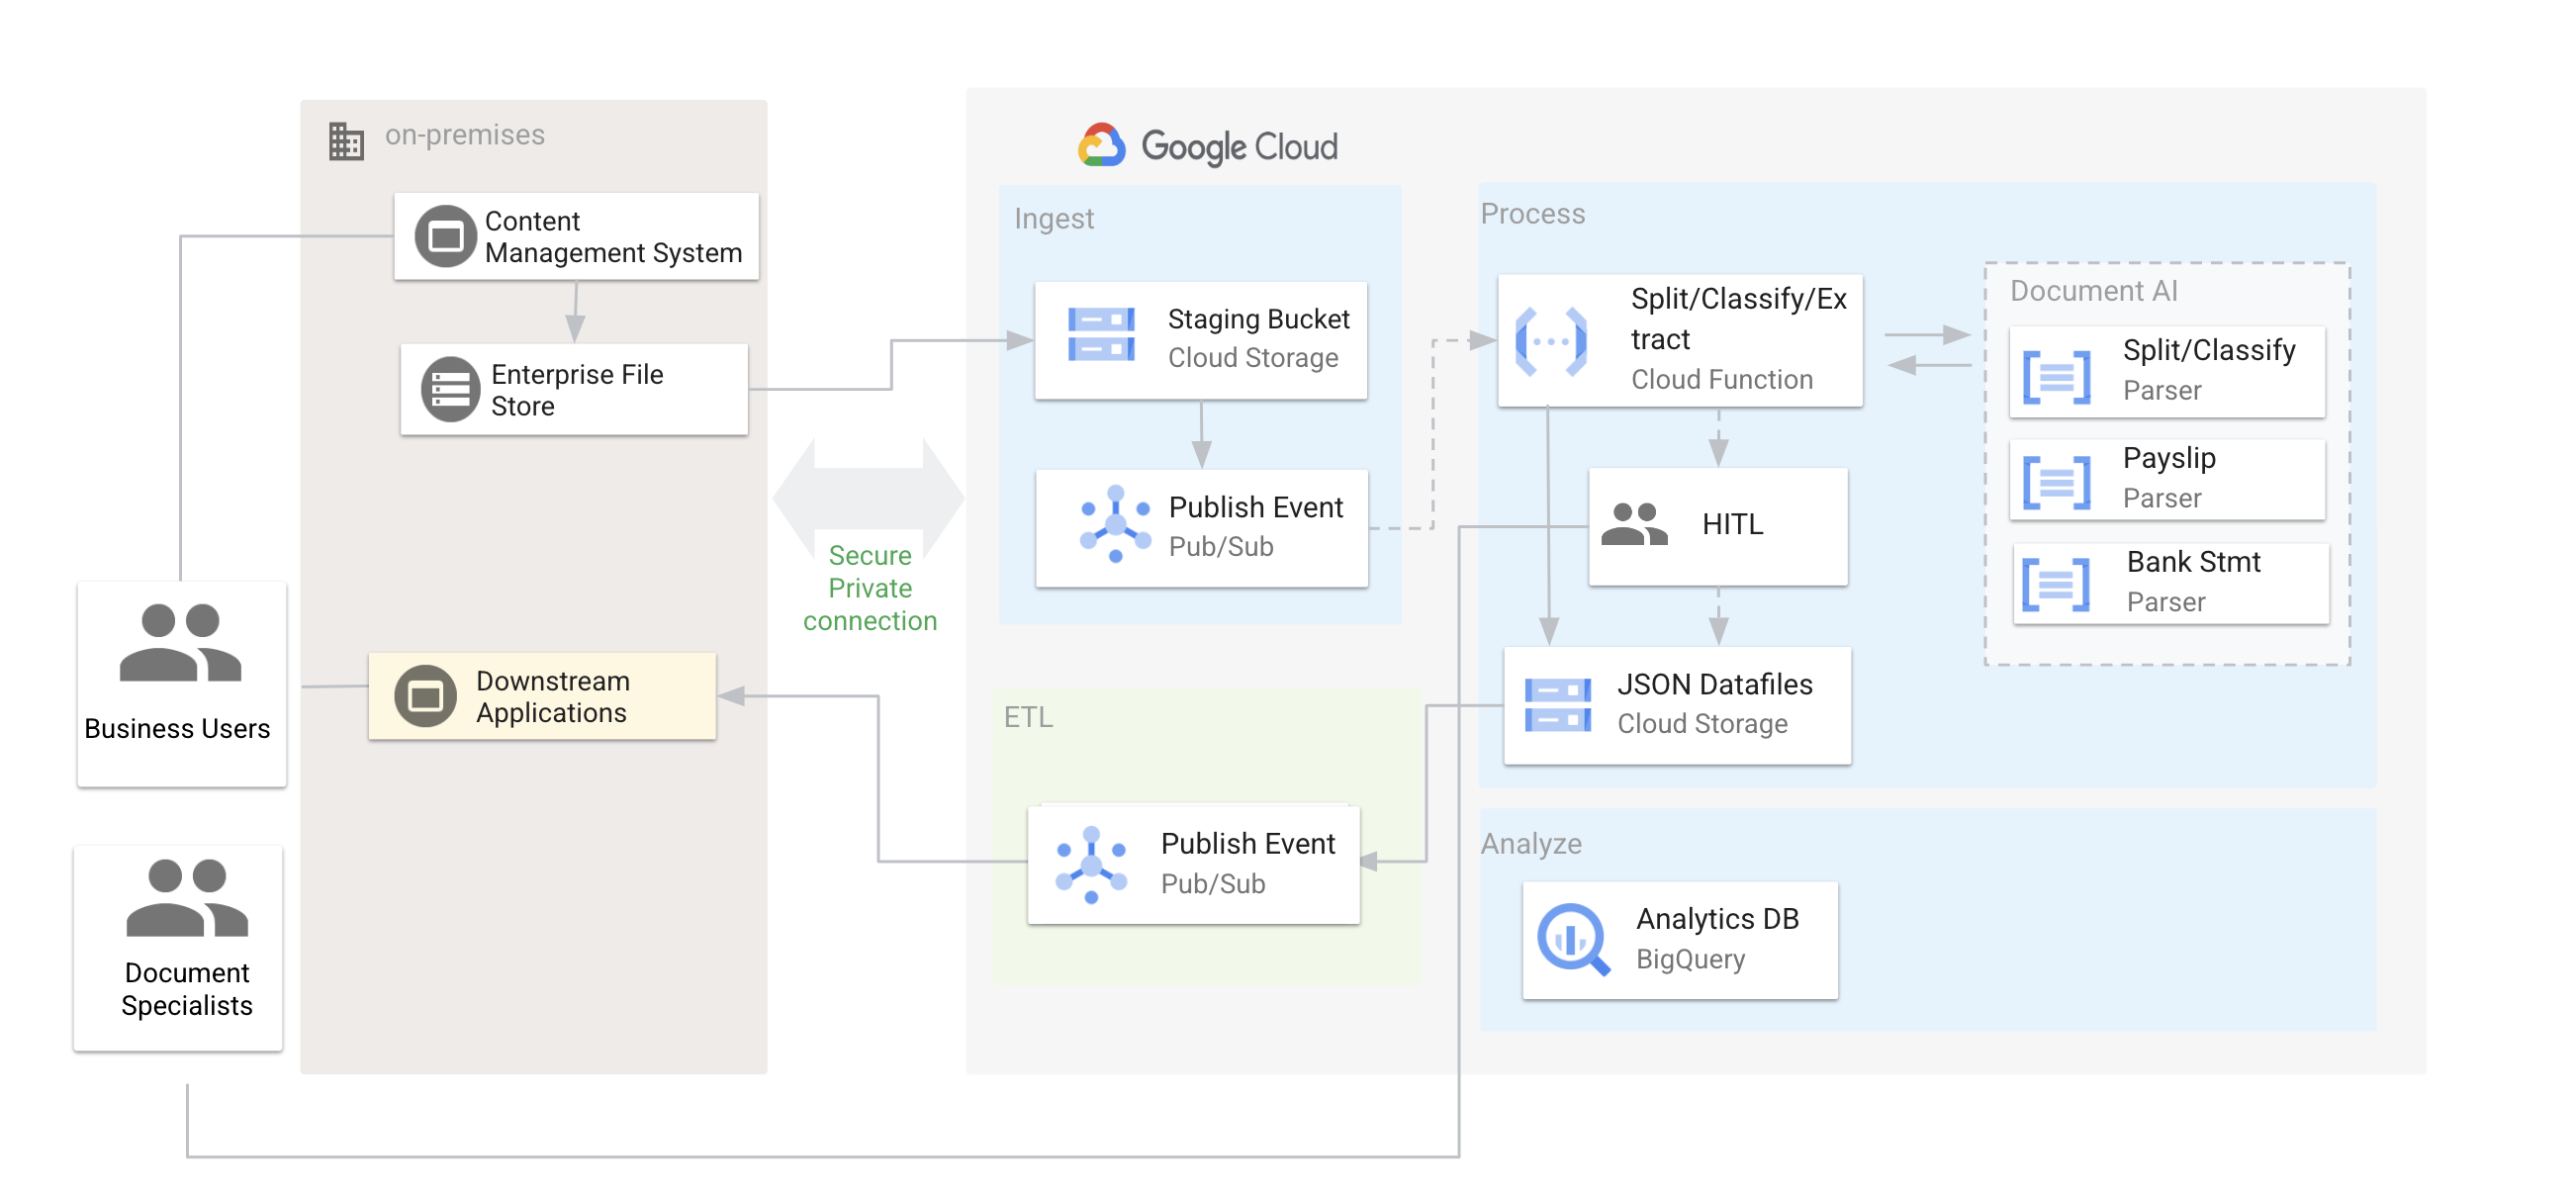

You must replace the `processor_id` variable value in the the second cell with the appropriate value for the Processor ID of the Document AI processor that you want to use. The processor may not support all of the Document AI output properties. Entity data is only returned by processors that use specialized parsers for example. 

In [20]:
# Import Libraries
from google.cloud import documentai_v1beta3 as documentai
from google.cloud import storage

import re
import os
import pandas as pd
import simplejson as json


In [21]:
# Set your Processor ID
processor_id = "1d09f1baa4344a28" 

In [22]:
# Set your variables
project_id = %system gcloud config get-value core/project
project_id = project_id[0]
location = 'us'           
gcs_input_bucket  = "experiment-megha-bucket"
gcs_input_prefix  = "in/"                     
gcs_output_bucket = "experiment-megha-bucket"
gcs_output_prefix = "out/"                   
timeout = 300

E0426 16:51:57.911949680   23863 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [23]:
# Define Google Cloud client objects
client_options = {"api_endpoint": "{}-documentai.googleapis.com".format(location)}
client = documentai.DocumentProcessorServiceClient(client_options=client_options)
storage_client = storage.Client()

In [24]:
# Create input configuration
blobs = storage_client.list_blobs(gcs_input_bucket, prefix=gcs_input_prefix)
input_configs = []
print("Input Files:")
for blob in blobs:
    if ".PDF" in blob.name:
        source = "gs://{bucket}/{name}".format(bucket = gcs_input_bucket, name = blob.name)
        print(source)
        input_config = documentai.types.document_processor_service.BatchProcessRequest.BatchInputConfig(
            gcs_source=source, mime_type="application/pdf"
        )
        input_configs.append(input_config)


Input Files:
gs://experiment-megha-bucket/in/AVRD_06.PDF
gs://experiment-megha-bucket/in/GNEW_003.PDF
gs://experiment-megha-bucket/in/MOXA_07.PDF
gs://experiment-megha-bucket/in/PURL_07.PDF
gs://experiment-megha-bucket/in/PURL_18.PDF
gs://experiment-megha-bucket/in/RMAQ_07.PDF
gs://experiment-megha-bucket/in/RMAQ_08.PDF


In [25]:
# Create output configuration
destination_uri = f"gs://{gcs_output_bucket}/{gcs_output_prefix}"
output_config = documentai.types.document_processor_service.BatchProcessRequest.BatchOutputConfig(
    gcs_destination=destination_uri
)

In [26]:
# Create the Document AI API request
name = f"projects/{project_id}/locations/{location}/processors/{processor_id}"
request = documentai.types.document_processor_service.BatchProcessRequest(
    name=name,
    input_configs=input_configs,
    output_config=output_config,
)


In [27]:
# Start the batch (asynchronous) API operation 
operation = client.batch_process_documents(request)
# Wait for the operation to finish
operation.result(timeout=timeout)
print ("Batch process  completed.")

Batch process  completed.


In [ ]:
# Fetch list of output files
match = re.match(r"gs://([^/]+)/(.+)", destination_uri)
output_bucket = match.group(1)
prefix = match.group(2)
bucket = storage_client.get_bucket(output_bucket)
blob_list = list(bucket.list_blobs(prefix=prefix))

In [ ]:
# Display detected text from asynchronous output JSON files
for i, blob in enumerate(blob_list):
    # If JSON file, download the contents of this blob as a bytes object.
    if ".json" in blob.name:
        blob_as_bytes = blob.download_as_bytes()
        document = documentai.types.Document.from_json(blob_as_bytes)
        print(f"Fetched file {i + 1}:{blob.name}")
        # print the text data output from the processor
        print(f"Text Data:\n {document.text}")
    else:
        print(f"Skipping non-supported file type {blob.name}")

In [ ]:
# Display entity data from asynchronous output JSON files
for i, blob in enumerate(blob_list):
    # If JSON file, download the contents of this blob as a bytes object.
    if ".json" in blob.name:
        blob_as_bytes = blob.download_as_bytes()
        document = documentai.types.Document.from_json(blob_as_bytes)
        print(f"Fetched file {i + 1}:{blob.name}")
        # print the entity data output from the processor
        if 'entities' in dir(document):
            entities=document.entities
            table = PrettyTable(['Type', 'Value', 'Confidence'])
            entities_found = 0
            for entity in entities:
               entity_type = entity.type_
               value = entity.mention_text
               confidence = round(entity.confidence,4)
               table.add_row([entity_type, value, confidence])
            print(table._rows.count())   
        else:
            print('No entity data returned by the Document AI processor for file'+blob.name)
    else:
        print(f"Skipping non-supported file type {blob.name}")